# Own dataset for predicting resp rate from ECG
### Decided to make a regression model for creating respiratory signal from ECG

In [55]:
import random
import os
import numpy as np
import pickle
import torch
from tqdm import tqdm
import neurokit2 as nk
from torch.utils.data import Dataset, DataLoader
from scipy.interpolate import interp1d
from matplotlib import pyplot as plt
from customLib.preprocess import *
from models.models import LSTM
from customLib.peak_detection import find_mean_avg_r_peak_indices, detect_nk
from customLib.dataset import split_dataset

In [2]:
root_path = "./aidmed_ecgs/with_resp"
aidmed_ecg_sampling_rate = 250
aidmed_resp_sampling_rate = 50
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
files = [x for x in os.listdir(root_path)]

ecgs = [os.path.join(root_path, x) for x in files[0::3]]
resps =  [os.path.join(root_path, x) for x in files[1::3]]
annotations =  [os.path.join(root_path, x) for x in files[2::3]]

assert len(files) == len(ecgs) + len(resps) + len(annotations)
assert (len(ecgs) + len(resps) + len(annotations)) % 3 == 0

In [47]:
def shift_windows(ecg, resp, annotation):
    """
    Function for shifting one of the signals if they happen to have different time stamps

    Args:
    ecg - a 2D array where the second column (index 1) is timestamps, first column (index 0) is ecg values
    resp - a 2D array where the second column (index 1) is timestamps, first column (index 0) is resp values
    annotation - a 1D array of RESP local maxima indices
    """
    # Accessing the timestamps correctly from index 1
    ecg_first_timestep = ecg[0, 1]
    ecg_last_timestep = ecg[-1, 1]

    resp_first_timestep = resp[0, 1]
    resp_last_timestep = resp[-1, 1]

    try:
        if ecg_first_timestep != resp_first_timestep:
            raise ValueError("start-mismatch")
        if ecg_last_timestep != resp_last_timestep:
            raise ValueError("end-mismatch")
    except ValueError as e:
        if str(e) == "start-mismatch":
            print("Start mismatch detected.")
            if ecg_first_timestep < resp_first_timestep:
                # Find index where ECG timestamps are >= the first RESP timestamp
                mismatch_idx = np.where(ecg[:, 1] >= resp_first_timestep)[0][0]
                ecg = ecg[mismatch_idx:]  # Remove earlier timestamps in ECG
            else:
                # Find index where RESP timestamps are >= the first ECG timestamp
                mismatch_idx = np.where(resp[:, 1] >= ecg_first_timestep)[0][0]
                resp = resp[mismatch_idx:]  # Remove earlier timestamps in RESP
                annotation = annotation - mismatch_idx  # Shift annotation indices
                annotation = annotation[annotation > 0]  # Keep only valid positive indices
        elif str(e) == "end-mismatch":
            print("End mismatch detected.")
            if ecg_last_timestep < resp_last_timestep:
                # Find index where RESP timestamps are >= the last ECG timestamp
                mismatch_idx = np.where(resp[:, 1] >= ecg_last_timestep)[0][0]
                resp = resp[:mismatch_idx]  # Remove later timestamps in RESP
                annotation = annotation[annotation < mismatch_idx]  # Adjust annotation
            else:
                # Find index where ECG timestamps are >= the last RESP timestamp
                mismatch_idx = np.where(ecg[:, 1] >= resp_last_timestep)[0][0]
                ecg = ecg[:mismatch_idx]  # Remove later timestamps in ECG
        else:
            raise Exception("An unknown data timestamp mismatch occurred.")
    finally:
        # Ensure resp and ecg are 1D after adjusting
        if len(ecg.shape) > 1:
            ecg = ecg[:, 0]  # Assuming first column has RESP values
        if len(resp.shape) > 1:
            resp = resp[:, 0]  # Assuming first column has ECG values

        #print("ECG shape:", ecg_values.shape, " Time:", ecg_values.shape[0] / aidmed_ecg_sampling_rate)
        #print("RESP shape:", resp_values.shape, " Time:", resp_values.shape[0] / aidmed_resp_sampling_rate)

    return ecg, resp, annotation


In [48]:
def plot_ecg_resp(ecg, resp, annotation=None):
    fig, axs = plt.subplots(nrows=2)

    t_ecg = [x * 1/aidmed_ecg_sampling_rate for x in range(ecg.shape[0])]
    t_resp = [x * 1/aidmed_resp_sampling_rate for x in range(resp.shape[0])]

    ax = axs[0]
    ax.plot(t_ecg, ecg)
    ax.grid()

    ax = axs[1]
    ax.plot(t_resp, resp)
    if annotation:
        ax.plot(annotation * 1/aidmed_resp_sampling_rate, resp[annotation], 'rx')
    ax.grid()

    fig.show()

In [49]:
def pad_signals(window_in_seconds, longest_sequence_length):
    ecg_window_length = window_in_seconds * aidmed_ecg_sampling_rate
    resp_window_length = window_in_seconds * aidmed_resp_sampling_rate

    ecg_target_window_length = longest_sequence_length * aidmed_ecg_sampling_rate
    resp_target_window_length = longest_sequence_length * aidmed_resp_sampling_rate

    x, y = np.empty((0, ecg_target_window_length)), np.empty((0, resp_target_window_length, 2))

    for i, (ecg, resp, annotation) in enumerate(zip(ecgs, resps, annotations)):
        ecg = np.load(ecg)
        resp = np.load(resp)
        with open(annotation, "rb") as f:
            resp_peak_indices = pickle.load(f)

        annotation = np.zeros((resp.shape[0]))
        annotation[resp_peak_indices] = 1

        ecg, resp, annotation = shift_windows(ecg, resp, annotation)
        ecg = myConv1D(signal=ecg, kernel_length=5, padding="same")

        ecg_windows = split_signal(ecg, start=0, window_in_seconds=window_in_seconds, fs=aidmed_ecg_sampling_rate, overlap_factor=0.85, normalize=(True, (-1,1)), denoise=False)
        resp_windows = split_signal(resp, start=0, window_in_seconds=window_in_seconds, fs=aidmed_resp_sampling_rate, overlap_factor=0.85, normalize=(True, (0,1)), denoise=False)
        annotation_windows = split_signal(annotation, start=0, window_in_seconds=window_in_seconds, fs=aidmed_resp_sampling_rate, overlap_factor=0.85, normalize=False, denoise=False)

        if len(ecg_windows) > 0:
            if ecg_window_length != ecg_target_window_length:
                padding_begining = np.random.randint(low=0, high=ecg_target_window_length - ecg_window_length, dtype=int)
                padding_end = ecg_target_window_length - ecg_window_length - padding_begining
                ecg_windows = np.pad(array=np.array(ecg_windows), pad_width=((0,0), (padding_begining, padding_end)), mode="mean")

            if resp_window_length != resp_target_window_length:
                padding_begining = int(padding_begining * aidmed_resp_sampling_rate / aidmed_ecg_sampling_rate)
                padding_end = resp_target_window_length - resp_window_length - padding_begining
                resp_windows = np.pad(array=np.array(resp_windows), pad_width=((0,0), (padding_begining, padding_end)), mode="edge")
                annotation_windows = np.pad(array=np.array(annotation_windows), pad_width=((0,0), (padding_begining, padding_end)), mode="constant", constant_values=(0))
            
            resp_and_annotation_windows = np.stack((resp_windows, annotation_windows), axis=-1)
            x = np.concatenate((x, ecg_windows), axis=0)
            y = np.concatenate((y, np.array(resp_and_annotation_windows)), axis=0)
            
    return x, y


In [50]:
#x_30, y_30 = pad_signals(window_in_seconds=30, longest_sequence_length=30)
x_45, y_45 = pad_signals(window_in_seconds=45, longest_sequence_length=45)
#x_60, y_60 = pad_signals(window_in_seconds=60, longest_sequence_length=60)

#x = np.concatenate((x_30, x_45, x_60), axis=0)
#y = np.concatenate((y_30, y_45, y_60), axis=0)

End mismatch detected.


In [51]:
batch_size = 64

x = x_45
y = y_45

# # Prediction using LSTM for R-peaks detection
# r_peaks_prediction = []
# num_batches = int(np.ceil(x.shape[0] / batch_size))
# model = LSTM(input_dim=1, hidden_size=32, loss_pos_weight=torch.Tensor([17]).to(device))
# model.load_state_dict(torch.load("./checkpoints/lstm/raw_ecgs/lstm_epoch_10_acc_99.88_f1_0.98.pt"))

# model.eval()
# for batch_idx in range(num_batches):
#     start_idx = batch_idx * batch_size
#     end_idx = min((batch_idx + 1) * batch_size, x.shape[0])

#     x_batch = x[start_idx:end_idx]
#     x_batch = np.expand_dims(x_batch, axis=2)

#     x_tensor = torch.Tensor(x_batch).to(device)

#     prediction = model(x_tensor)
#     prediction = prediction.detach().cpu().numpy()
#     r_peaks_batch = (prediction >= 0.5).astype(int)
#     r_peaks_batch = r_peaks_batch.reshape((r_peaks_batch.shape[0], r_peaks_batch.shape[1]))
#     r_peaks_batch = [find_mean_avg_r_peak_indices(x) for x in r_peaks_batch]

#     r_peaks_prediction.append(r_peaks_batch)

# Prediction using neurokit
r_peaks_prediction = np.empty((0, x.shape[1]))
for ecg in x:
   ecg_peaks_indices = detect_nk(ecg_slice=ecg, fs=aidmed_ecg_sampling_rate)
   ecg_peaks = np.zeros_like(ecg)
   ecg_peaks[ecg_peaks_indices] = 1
   ecg_peaks = np.expand_dims(ecg_peaks, 0)
   r_peaks_prediction = np.concatenate((r_peaks_prediction, ecg_peaks), axis=0)


In [52]:
sample = 10

# LSTM prediction
single_peaks_pred = r_peaks_prediction[sample]
R_wave_indices = np.where(single_peaks_pred == 1)[0]

# nuerokit prediction
r_peaks = detect_nk(ecg_slice=x[sample], fs=250)

RRs_nk = np.diff(r_peaks) * 1/aidmed_ecg_sampling_rate * 1000
RRs_nk = [np.mean(RRs_nk).tolist()] + RRs_nk.tolist()

RRs = np.diff(R_wave_indices) * 1/aidmed_ecg_sampling_rate * 1000

# Extend the R_wave_indices and RRs for interpolation
R_wave_indices_interpolation = np.concatenate(([0], R_wave_indices.tolist(), [len(single_peaks_pred)]), axis=0)
RRs_interpolation = np.concatenate(([np.mean(RRs)], RRs, [RRs[-1], np.mean(RRs)]))

zoh = interp1d(R_wave_indices_interpolation, RRs_interpolation, kind="zero")
t_interpolate = [x for x in range(len(single_peaks_pred))]

interpolation = zoh(t_interpolate)

RRs = [np.mean(RRs).tolist()] + RRs.tolist()

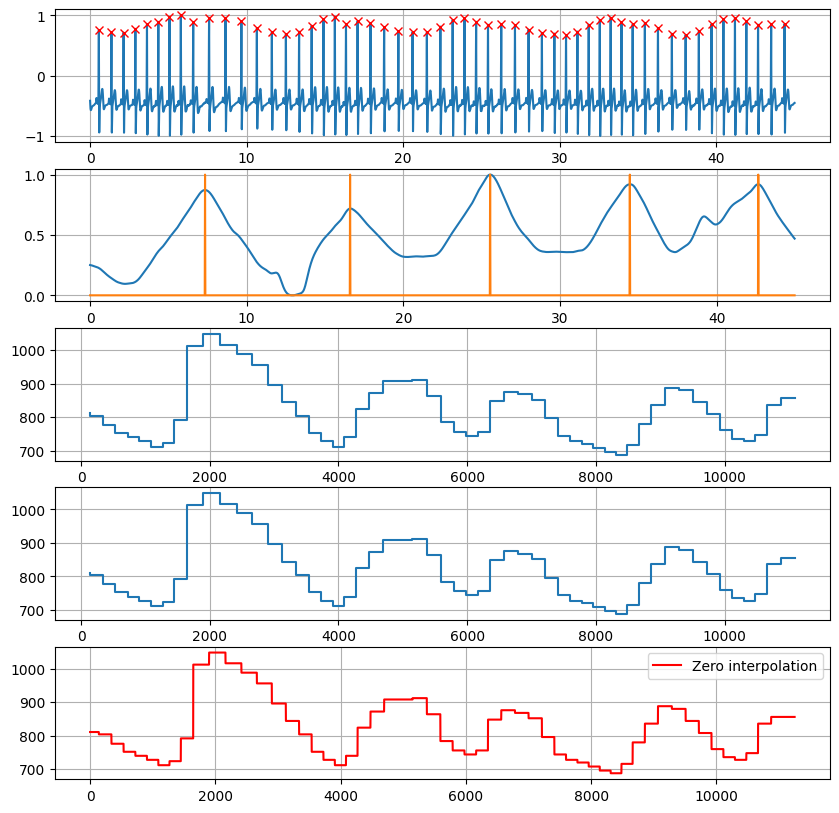

In [53]:
t = [x * 1/ aidmed_ecg_sampling_rate for x in range(len(x[sample]))]
t_resp = [x * 1/ aidmed_resp_sampling_rate for x in range(len(y[sample]))]

fig, axs = plt.subplots(nrows=5)

ax = axs[0]
ax.grid()
ax.plot(t, x[sample])
ax.plot(R_wave_indices * 1/ aidmed_ecg_sampling_rate, x[sample][R_wave_indices], 'rx')

ax = axs[1]
ax.plot(t_resp, y[sample][:,0])
ax.plot(t_resp, y[sample][:,1])
ax.grid()

ax = axs[2]
ax.step(R_wave_indices, RRs)
ax.grid()

ax = axs[3]
ax.step(r_peaks, RRs_nk)
ax.grid()

ax = axs[4]
ax.plot([ x for x in range(len(interpolation))], interpolation, 'r')
ax.grid()
ax.legend(["Zero interpolation"])

fig.set_size_inches(10,10)

In [11]:
zoh_form_wave = []

for prediction in r_peaks_prediction:
    R_wave_indices_interpolation = np.where(prediction == 1)[0]
    RRs_interpolation = np.diff(R_wave_indices_interpolation) * 1/aidmed_ecg_sampling_rate * 1000
    RRs_interpolation = norm_min_max(signal=RRs_interpolation, lower=-1, upper=1)

    if 0 not in R_wave_indices_interpolation:
        R_wave_indices_interpolation = np.concatenate(([0], R_wave_indices_interpolation), axis=0)
        RRs_interpolation = np.concatenate(([np.mean(RRs_interpolation)], RRs_interpolation), axis=0)

    if len(prediction) not in R_wave_indices:
        R_wave_indices_interpolation = np.concatenate((R_wave_indices_interpolation, [len(prediction)]), axis=0)
        RRs_interpolation = np.concatenate((RRs_interpolation, [RRs_interpolation[-1], np.mean(RRs_interpolation)]), axis=0)
    
    zoh = interp1d(R_wave_indices_interpolation, RRs_interpolation, kind="zero")
    t_interpolate = [x for x in range(len(prediction))]
    interpolation = zoh(t_interpolate)

    zoh_form_wave.append(interpolation)


x_stacked = np.stack((x, np.array(zoh_form_wave)), axis=2)

In [54]:
foh_waveform = []

for prediction in r_peaks_prediction:
    R_wave_indices_interpolation = np.where(prediction == 1)[0]
    RRs_interpolation = np.diff(R_wave_indices_interpolation) * 1/aidmed_ecg_sampling_rate * 1000
    RRs_interpolation = norm_min_max(signal=RRs_interpolation, lower=0, upper=1)

    if 0 not in R_wave_indices_interpolation:
        R_wave_indices_interpolation = np.concatenate(([0], R_wave_indices_interpolation), axis=0)
        RRs_interpolation = np.concatenate(([np.mean(RRs_interpolation)], RRs_interpolation), axis=0)

    if len(prediction) not in R_wave_indices:
        R_wave_indices_interpolation = np.concatenate((R_wave_indices_interpolation, [len(prediction)]), axis=0)
        RRs_interpolation = np.concatenate((RRs_interpolation, [RRs_interpolation[-1], np.mean(RRs_interpolation)]), axis=0)
    
    foh = interp1d(R_wave_indices_interpolation, RRs_interpolation, kind="linear")
    t_interpolate = [x for x in range(len(prediction))]
    interpolation = foh(t_interpolate)

    foh_waveform.append(interpolation)


x_stacked = np.stack((x, np.array(foh_waveform)), axis=2)

In [13]:
# sample = 20

# test = torch.Tensor(x_stacked[sample][:,0].reshape(1,x.shape[1],1)).to(device)
# r_peaks = model(test)
# r_peaks = r_peaks.detach().cpu().numpy()
# r_peaks = np.where(r_peaks > 0.5, 1, 0)
# r_peaks = find_mean_avg_r_peak_indices(r_peaks)
# r_peaks = np.where(r_peaks == 1)[0]

# fig, axs = plt.subplots(nrows=2)

# t = [x * 1/aidmed_ecg_sampling_rate for x in range(x_stacked.shape[1])]

# ax = axs[0]
# ax.grid()
# ax.plot(t, x_stacked[sample][:, 0])
# ax.plot(r_peaks * 1/ aidmed_ecg_sampling_rate, x_stacked[-1][r_peaks, 0], 'rx')

# ax = axs[1]
# ax.plot(t, x_stacked[sample][:, 1], 'r')
# ax.grid()
# ax.legend(["FOH interpolation"])

In [63]:
from torch import nn
import torch.nn.functional as F

def snake_activation(x):
    return x * torch.sin(x) ** 2  # Snake: x * sin^2(x)

class ConvBackbone(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ConvBackbone, self).__init__()
    
        self.conv_backbone = nn.ModuleList([
            nn.Conv1d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1),
            nn.MaxPool1d(kernel_size=5, stride=5),  # Reduce sequence length by 5x
        ])
    
    def forward(self, x):
        x = x.permute(0, 2, 1)
        for layer in self.conv_backbone:
            x = layer(x)
        x = x.permute(0, 2, 1)
        return x

class RespToECG(nn.Module):
    def __init__(self, input_size=2, hidden_size=64, input_seq_length=7500, output_seq_length=1500):
        super(RespToECG, self).__init__()

        self.lstm_1 = torch.nn.LSTM(input_size=input_size, hidden_size=hidden_size, batch_first=True, bidirectional=True, dropout=0.3)
        self.lstm_2 = torch.nn.LSTM(input_size=2*hidden_size, hidden_size=hidden_size, bidirectional=True, batch_first=True)
        self.dense_1 = torch.nn.Linear(in_features=2*hidden_size, out_features=1)
        self.dense_2 = torch.nn.Linear(in_features=input_seq_length, out_features=output_seq_length)

        self.kernel_size=20
        self.smoothening_kernel = torch.FloatTensor([[[1/self.kernel_size for _ in range(self.kernel_size)]]]).to(device)
        self.to(device)

    def forward(self, x):
        x, _ = self.lstm_1(x)
        x, _ = self.lstm_2(x)
        x = self.dense_1(x)
        x = x.squeeze()
        x = self.dense_2(x)
        x = x.unsqueeze(2)
        x = x.permute((0,2,1))
        x = F.conv1d(x, weight=self.smoothening_kernel, padding="same")
        x = x.permute((0,2,1))
        x = x.squeeze()
        return x
    
class RespNet(nn.Module):
    def __init__(self, input_size=2, hidden_size=64, input_seq_length=7500, output_seq_length=1500):
        super(RespNet, self).__init__()

        self.lstm_1 = torch.nn.LSTM(input_size=input_size, hidden_size=hidden_size, batch_first=True, bidirectional=True, dropout=0.3)
        self.lstm_2 = torch.nn.LSTM(input_size=2*hidden_size, hidden_size=hidden_size, bidirectional=True, batch_first=True)
        #self.conv_backbone = ConvBackbone()
        self.dense_1 = torch.nn.Linear(in_features=2*hidden_size, out_features=1)
        self.dense_2 = torch.nn.Linear(in_features=input_seq_length, out_features=output_seq_length)
        self.dense_3 = torch.nn.Linear(in_features=output_seq_length, out_features=output_seq_length)

        self.to(torch.device("cuda:0" if torch.cuda.is_available() else "cpu"))

    def forward(self, x):
        x, _ = self.lstm_1(x)
        x, _ = self.lstm_2(x)

        x = self.dense_1(x)
        x = x.squeeze()
        resp_regression = self.dense_2(x)

        resp_peaks = self.dense_3(resp_regression)

        return resp_regression, resp_peaks

In [15]:
class DeviceDataset(Dataset):
  def __init__(self, data, labels):
    super(DeviceDataset, self).__init__()
    self.data = data
    self.labels = labels
    self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

  def __len__(self):
    return self.data.shape[0]
  
  def __getitem__(self, idx):
    sample = torch.tensor(self.data[idx], dtype=torch.float32).to(self.device)
    label = torch.tensor(self.labels[idx], dtype=torch.float32).to(self.device)
    return sample, label

In [16]:
x_train, y_train, x_test, y_test = split_dataset(x=x_stacked, y=y_45, is_validation_set=False, shuffle=True)

#x_train = x_train[:20]
#y_train = y_train[:20]

#x_train = np.expand_dims(x_train, 2)
#x_test = np.expand_dims(x_test, 2)

train_dataset = DeviceDataset(data=x_train, labels=y_train)
test_dataset = DeviceDataset(data=x_test, labels=y_test)

train_loader = DataLoader(dataset=train_dataset, batch_size=32)
test_loader = DataLoader(dataset=test_dataset, batch_size=32)

Total X: 629


c:\Users\patry\OneDrive\Elearning - PG\WETI\masters-thesis\customLib\dataset.py:34: UserWarning: Path is not specified. The dataset is not being saved.
  warnings.warn("Path is not specified. The dataset is not being saved.")


In [17]:
model = RespToECG(input_size=2, input_seq_length=x_train.shape[1], output_seq_length=y_train.shape[1])

e:\anaconda3\envs\torch\Lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


In [61]:


def validate(model, val_loader):
    model.eval()  # Set the model to evaluation mode
    criterion = nn.L1Loss()
    epoch_val_loss = 0

    with torch.no_grad():  # Disable gradient calculation
        for i, (inputs, targets) in enumerate(val_loader):
            # Forward pass
            outputs = model(inputs)

            # Compute the loss
            loss = criterion(outputs, targets[:,:,0])
            epoch_val_loss += loss.item()

            rand_idx = random.randint(0, inputs.shape[0])
            try:
                input = inputs[rand_idx].detach().cpu().numpy()
                ecg = input[:, 0]
                rrs = input[:, 1]

                target = targets[rand_idx][:,0]
                target = target.detach().cpu().numpy()

                resp_regression = outputs[rand_idx]
                resp_regression = resp_regression.detach().cpu().numpy()

                rpeaks, info = nk.ecg_peaks(ecg, sampling_rate=aidmed_ecg_sampling_rate)
                ecg_rate = nk.ecg_rate(rpeaks, sampling_rate=aidmed_ecg_sampling_rate, desired_length=len(ecg))
                edr = nk.ecg_rsp(ecg_rate, sampling_rate=aidmed_ecg_sampling_rate)
                edr = resample_signal(signal=edr, num_samples=len(target))
                edr = norm_min_max(edr, lower=0, upper=1)

                if i % 5 == 0:
                    plt.figure()
                    plt.subplot(2,1,1)
                    plt.plot(ecg.flatten())
                    plt.legend(["ECG"])
                    plt.grid()
                    plt.subplot(2,1,1)
                    plt.plot(rrs.flatten())
                    plt.legend(["RRs"])
                    plt.grid()
                    plt.subplot(2,1,2)
                    plt.plot(target.flatten())
                    plt.plot(resp_regression.flatten(), 'r-')
                    plt.plot(edr.flatten(), 'b-')
                    plt.legend(["Target", "Regression", "EDR"])
                    plt.grid()
                    plt.show()
            except Exception as e:
                print(e)

    # Return the average validation loss
    return epoch_val_loss / len(val_loader)

def train(model, train_loader, val_loader, epochs=10, learning_rate=0.001):
    criterion = nn.L1Loss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    torch.cuda.empty_cache()

    for epoch in range(epochs):
        model.train()
        epoch_train_loss = 0

        for batch_idx, (inputs, targets) in tqdm(enumerate(train_loader), total=len(train_loader)):
            optimizer.zero_grad()

            outputs = model(inputs)

            loss = criterion(outputs, targets[:,:,0])
            loss.backward()
            optimizer.step()

            epoch_train_loss += loss.item()

        avg_val_loss = validate(model, val_loader)
        print(f'Epoch [{epoch+1}/{epochs}], Average Train Loss: {epoch_train_loss / len(train_loader)}, Average Validation Loss: {avg_val_loss}')

100%|██████████| 16/16 [00:14<00:00,  1.14it/s]


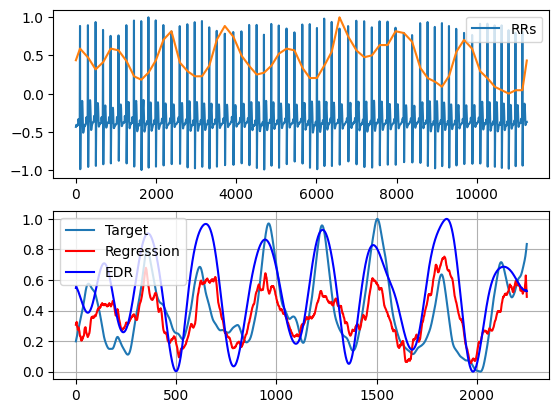

Epoch [1/20], Average Train Loss: 0.16213186737149954, Average Validation Loss: 0.17123353108763695


100%|██████████| 16/16 [00:13<00:00,  1.23it/s]


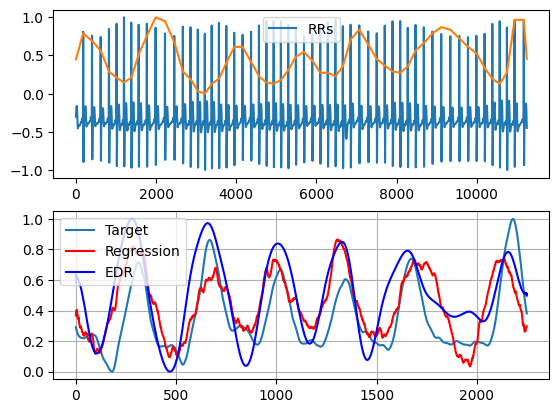

Epoch [2/20], Average Train Loss: 0.15775747410953045, Average Validation Loss: 0.17079168558120728


100%|██████████| 16/16 [00:13<00:00,  1.22it/s]


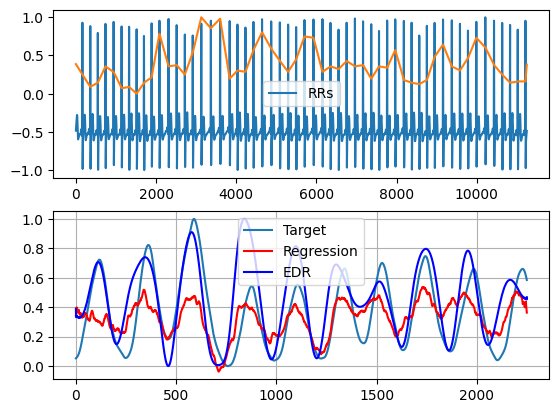

Epoch [3/20], Average Train Loss: 0.15748019609600306, Average Validation Loss: 0.17147061228752136


100%|██████████| 16/16 [00:13<00:00,  1.21it/s]


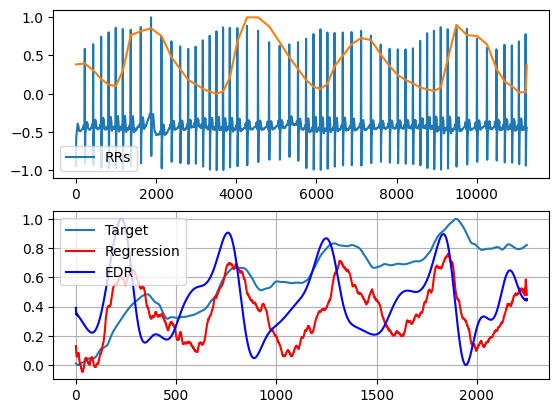

Epoch [4/20], Average Train Loss: 0.1575646484270692, Average Validation Loss: 0.17181436717510223


100%|██████████| 16/16 [00:12<00:00,  1.23it/s]


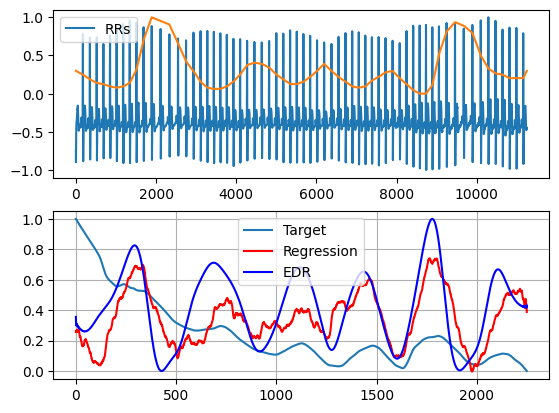

Epoch [5/20], Average Train Loss: 0.1574940774589777, Average Validation Loss: 0.1717146784067154


100%|██████████| 16/16 [00:13<00:00,  1.21it/s]


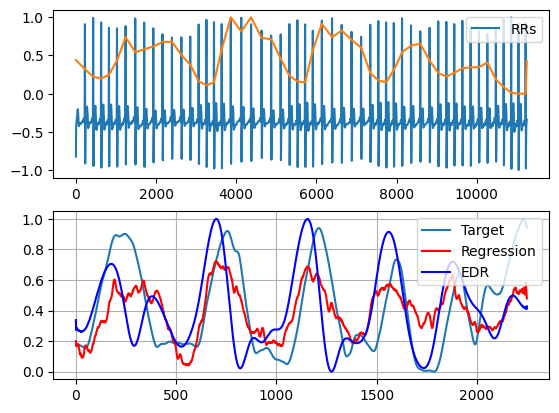

Epoch [6/20], Average Train Loss: 0.15760042611509562, Average Validation Loss: 0.17169541120529175


100%|██████████| 16/16 [00:12<00:00,  1.24it/s]


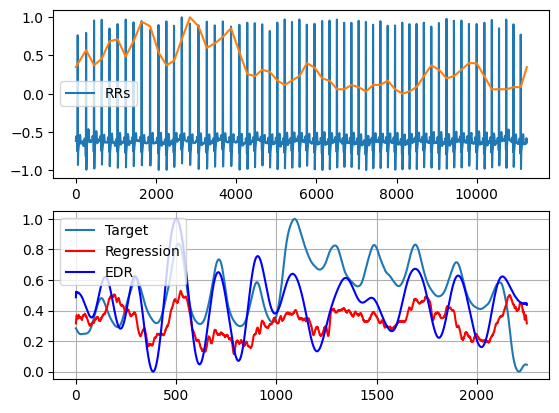

Epoch [7/20], Average Train Loss: 0.15751694235950708, Average Validation Loss: 0.17166253924369812


100%|██████████| 16/16 [00:12<00:00,  1.25it/s]


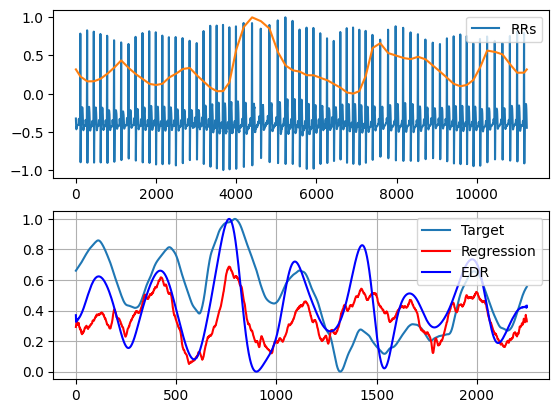

Epoch [8/20], Average Train Loss: 0.15734430868178606, Average Validation Loss: 0.17138579115271568


100%|██████████| 16/16 [00:12<00:00,  1.28it/s]


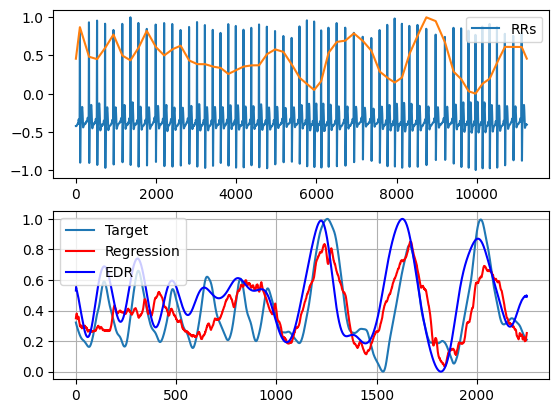

index 32 is out of bounds for dimension 0 with size 32
Epoch [9/20], Average Train Loss: 0.15711070224642754, Average Validation Loss: 0.17119649425148964


100%|██████████| 16/16 [00:12<00:00,  1.28it/s]


index 32 is out of bounds for dimension 0 with size 32
index 32 is out of bounds for dimension 0 with size 32
Epoch [10/20], Average Train Loss: 0.15690655168145895, Average Validation Loss: 0.17118467018008232


100%|██████████| 16/16 [00:12<00:00,  1.29it/s]


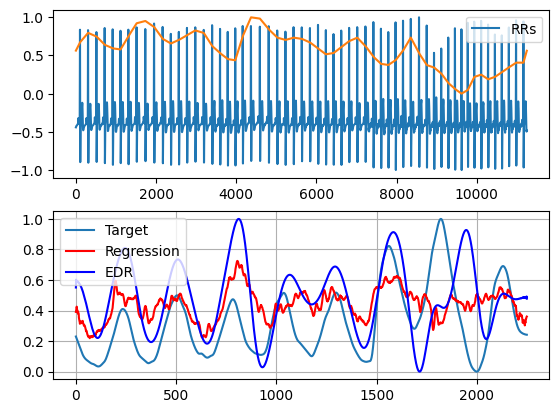

Epoch [11/20], Average Train Loss: 0.1567293517291546, Average Validation Loss: 0.17112857103347778


100%|██████████| 16/16 [00:11<00:00,  1.36it/s]


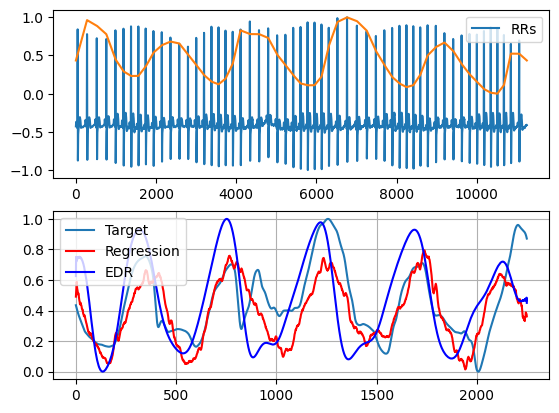

Epoch [12/20], Average Train Loss: 0.1565079754218459, Average Validation Loss: 0.17099826037883759


100%|██████████| 16/16 [00:11<00:00,  1.34it/s]


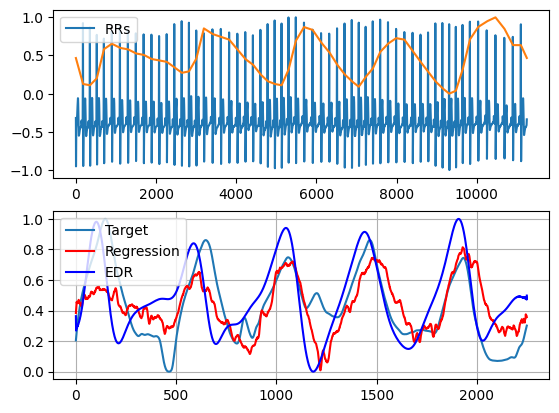

Epoch [13/20], Average Train Loss: 0.15626440662890673, Average Validation Loss: 0.17088308557868004


100%|██████████| 16/16 [00:11<00:00,  1.36it/s]


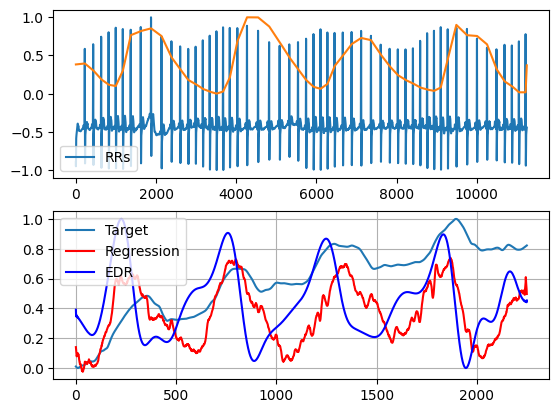

index 30 is out of bounds for dimension 0 with size 30
Epoch [14/20], Average Train Loss: 0.15599381737411022, Average Validation Loss: 0.17080363631248474


100%|██████████| 16/16 [00:11<00:00,  1.36it/s]


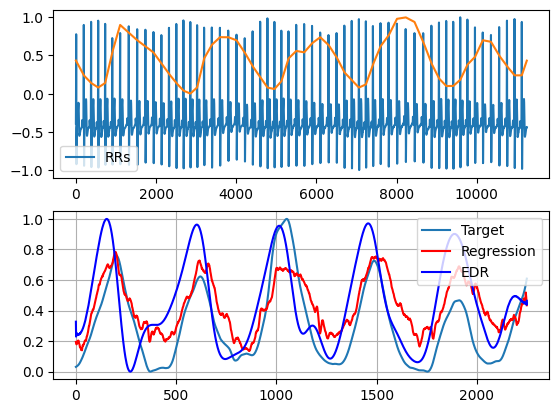

Epoch [15/20], Average Train Loss: 0.15579875838011503, Average Validation Loss: 0.17080902308225632


100%|██████████| 16/16 [00:11<00:00,  1.34it/s]


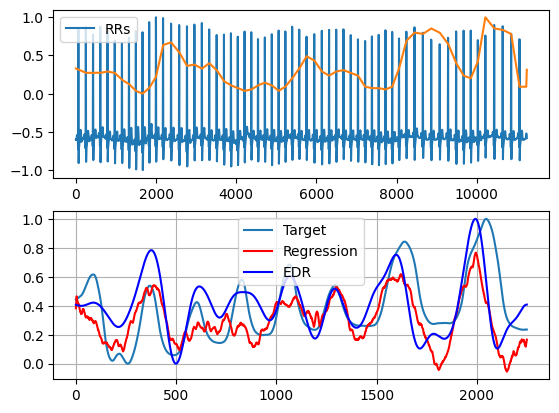

Epoch [16/20], Average Train Loss: 0.15555165894329548, Average Validation Loss: 0.17078302055597305


100%|██████████| 16/16 [00:12<00:00,  1.32it/s]


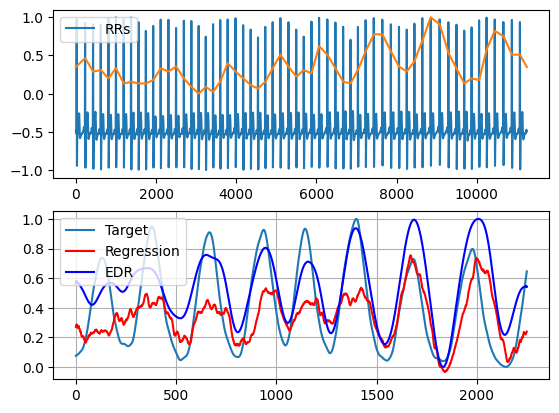

Epoch [17/20], Average Train Loss: 0.1552299214527011, Average Validation Loss: 0.17081940546631813


100%|██████████| 16/16 [00:11<00:00,  1.34it/s]


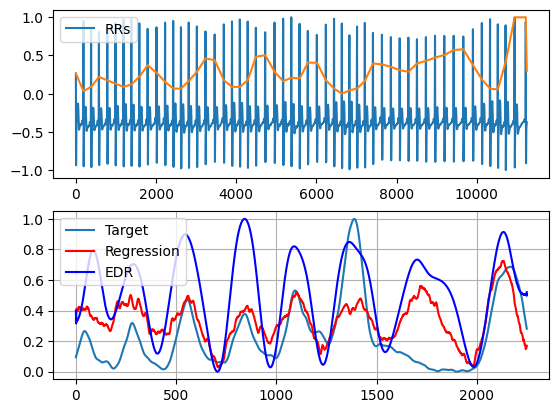

index 32 is out of bounds for dimension 0 with size 32
Epoch [18/20], Average Train Loss: 0.1548995105549693, Average Validation Loss: 0.17077533900737762


100%|██████████| 16/16 [00:11<00:00,  1.36it/s]


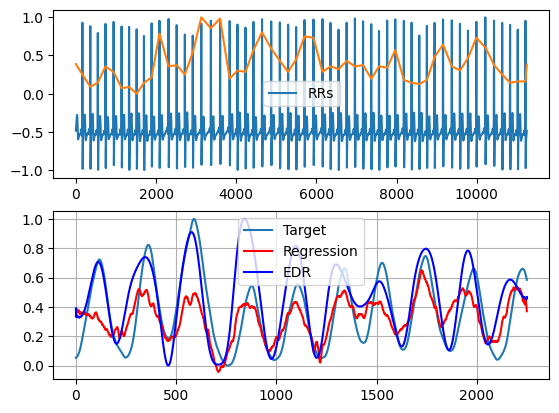

Epoch [19/20], Average Train Loss: 0.1545168673619628, Average Validation Loss: 0.17075666412711143


100%|██████████| 16/16 [00:11<00:00,  1.36it/s]


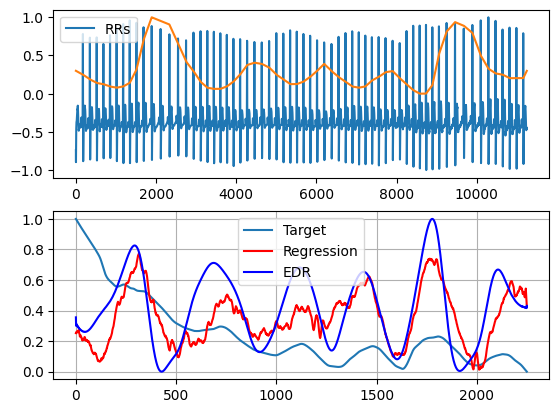

Epoch [20/20], Average Train Loss: 0.15418074931949377, Average Validation Loss: 0.17059464007616043


In [62]:
# total - 20 epochs
train(model, train_loader, test_loader, learning_rate=0.0001, epochs=20)

In [142]:
torch.save(model.state_dict(), "./regession_model.pt")

In [143]:
def test(model, test_loader):
    model.eval()  # Set the model to evaluation mode
    criterion = nn.MSELoss()  # Mean Squared Error Loss
    epoch_val_loss = 0

    with torch.no_grad():  # Disable gradient calculation
        for i, (inputs, targets) in enumerate(test_loader):
            # Forward pass
            outputs = model(inputs)

            # Compute the loss
            loss = criterion(outputs, targets)
            epoch_val_loss += loss.item()


            if i % 2 == 0:
                RRs = inputs[-1][:,1].detach().cpu().numpy()
                target = targets[-1].detach().cpu().numpy()
                pred = outputs[-1].detach().cpu().numpy()

                plt.figure()
                plt.plot(RRs)
                plt.grid()
                plt.title(f"Resp: {target}, Pred: {pred}")
                plt.show()

    # Return the average validation loss
    return epoch_val_loss / len(test_loader)

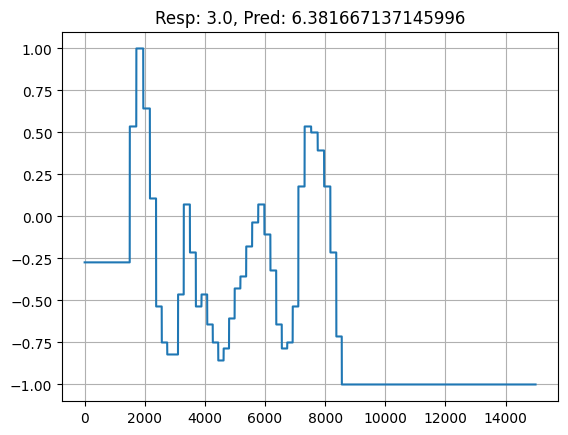

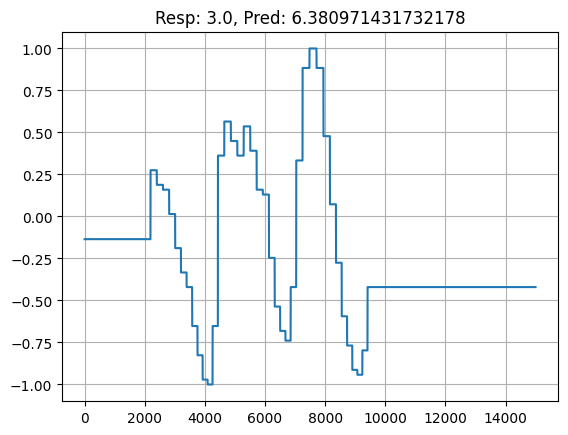

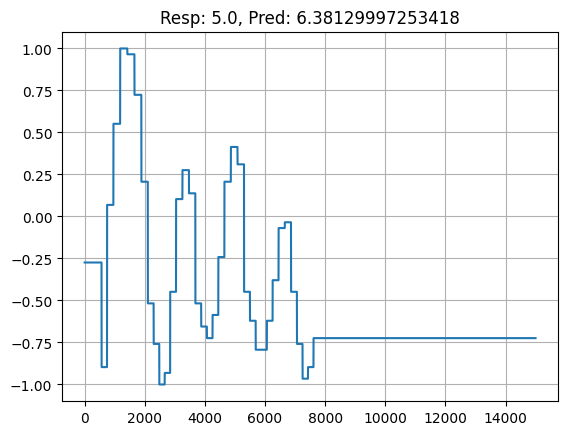

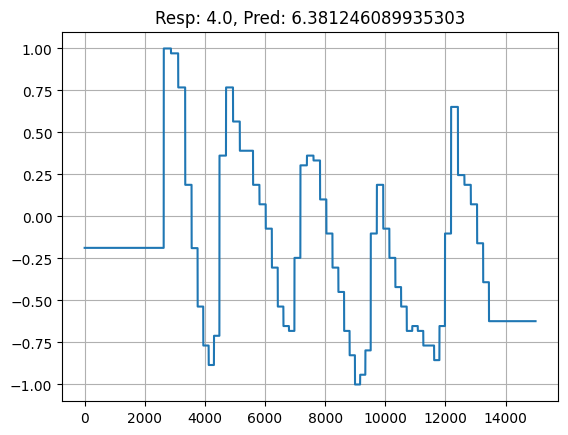

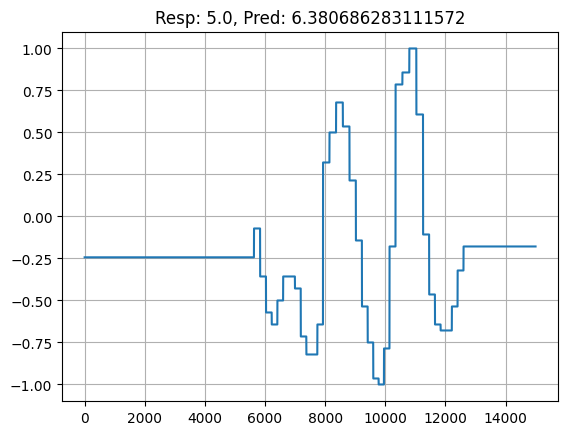

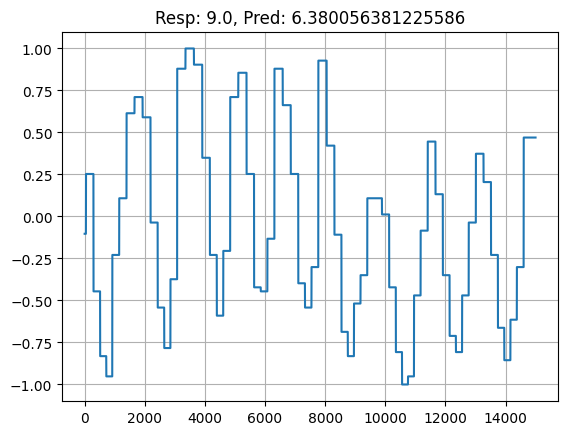

KeyboardInterrupt: 

In [144]:
test(model, test_loader)